<a href="https://colab.research.google.com/github/comandi1969/AIFFEL_Online_Quest/blob/main/Exploration02/Exploration02_News_Summary_Abstractive(rmsprop).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(3)

,headlines,text
92217,Airline staff accused of hitting woman with ba...,An American Airlines employee has been accused...
80609,Delhi government to auction VIP numbers for tw...,The Delhi government is planning to e-auction ...
89017,Piyush Goyal presides over largest efficient l...,The world's largest efficient lighting program...


In [3]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [4]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [5]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [7]:
sampled_data = data.head(3)

for idx, row in sampled_data.iterrows():
    print(f"Article: {row['text']}")
    print(f"Headlines: {row['headlines']}")
    print("-" * 50)  # This will print a separator line

Article: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
Headlines: upGrad learner switches to career in ML & Al with 90% salary hike
--------------------------------------------------
Article: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
Headlines: Delhi techie wins free food from Swiggy for one year on CRED
--------------------------------------------------
Article

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                          "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                          "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                          "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                          "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                          "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                          "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                          "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                          "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                          "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                          "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                          "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                          "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                          "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                          "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                          "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                          "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                          "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                          "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                          "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                          "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                          "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                          "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
#    sentence = sentence.lower() # 텍스트 소문자화
   sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
   sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
   sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
   sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
   sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
   sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
   sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

   # 불용어 제거 (Text)
   if remove_stopwords:
       tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
   # 불용어 미제거 (Summary)
   else:
       tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
   return tokens

In [11]:
temp_text = "Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."
temp_headline = "upGrad learner switches to career in ML & Al with 90% salary hike"

print("text: ", preprocess_sentence(temp_text, False))
print("headline:", preprocess_sentence(temp_headline, False))

text:  Saurav Kant an alumnus of upGrad and IIIT PG Program in Machine learning and Artificial Intelligence was Sr Systems Engineer at Infosys with almost years of work experience The program and upGrad degree career support helped him transition to Data Scientist at Tech Mahindra with salary hike upGrad Online Power Learning has powered lakh careers
headline: upGrad learner switches to career in ML Al with salary hike


In [12]:
# 전체 text 데이터에 대한 전처리
clean_text = []

for text in data['text']:
   clean_text.append(preprocess_sentence(text, False))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['Saurav Kant an alumnus of upGrad and IIIT PG Program in Machine learning and Artificial Intelligence was Sr Systems Engineer at Infosys with almost years of work experience The program and upGrad degree career support helped him transition to Data Scientist at Tech Mahindra with salary hike upGrad Online Power Learning has powered lakh careers', 'Kunal Shah credit card bill payment platform CRED gave users chance to win free food from Swiggy for one year Pranav Kaushik Delhi techie bagged this reward after spending CRED coins Users get one CRED coin per rupee of bill paid which can be used to avail rewards from brands like Ixigo BookMyShow UberEats Cult Fit and more', 'New Zealand defeated India by wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five match ODI series India lost an international match under Rohit Sharma captaincy after consecutive victories dating back to March The match witnessed India getting all out for their sevent

In [13]:
# 전체 headlines 데이터에 대한 전처리
clean_headline = []

for headline in data['headlines']:
   clean_headline.append(preprocess_sentence(headline, False))

print("headlines 전처리 후 결과: ", clean_headline[:5])

<ipython-input-10-8058fe1cf3d5>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


headlines 전처리 후 결과:  ['upGrad learner switches to career in ML Al with salary hike', 'Delhi techie wins free food from Swiggy for one year on CRED', 'New Zealand end Rohit Sharma led India match winning streak', 'Aegon life iTerm insurance plan helps customers save tax', 'Have known Hirani for yrs what if MeToo claims are not true Sonam']


In [14]:
data['text'] = clean_text
data['headlines'] = clean_headline

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 69
텍스트의 평균 길이 : 56.1561813745425
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.289406262708418


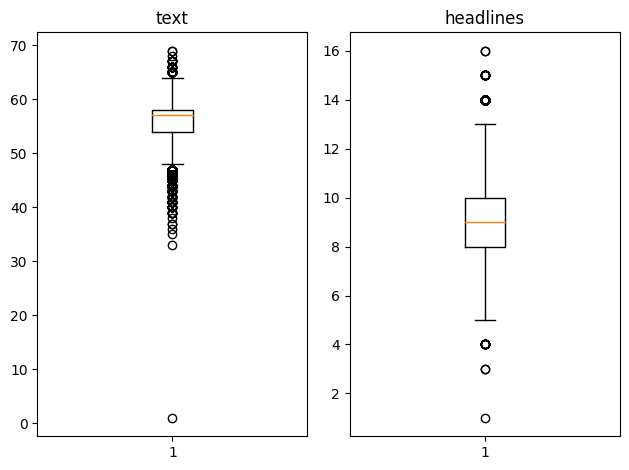

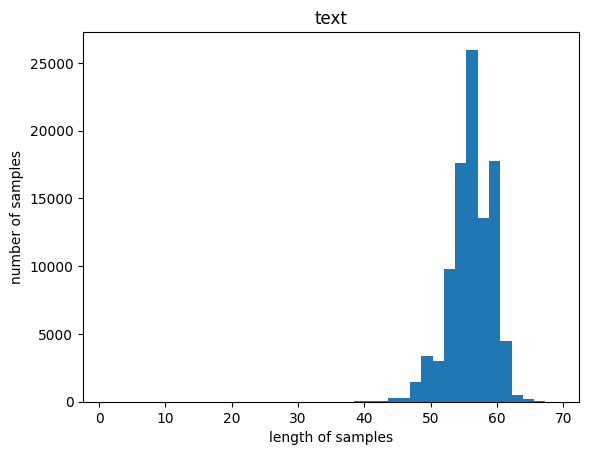

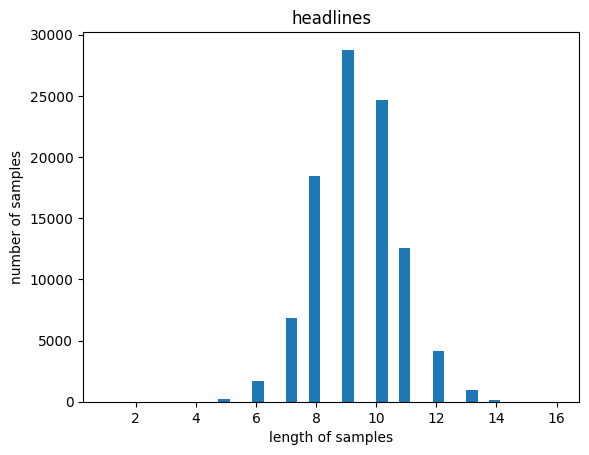

In [15]:
# 길이 분포 시각화
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']] # len(s.split())은 단어 수를 계산
headline_len = [len(s.split()) for s in data['headlines']] # len(s.split())은 단어 수를 계산

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headline_len)))
print('요약의 최대 길이 : {}'.format(np.max(headline_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headline_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
text_max_len = 60
headline_max_len = 12

In [17]:
def below_threshold_len(max_len, nested_list):
 cnt = 0
 for s in nested_list:
   if(len(s.split()) <= max_len):
       cnt = cnt + 1
 print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.9470414802765352
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9889589263928427


In [19]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len) & data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 92225


In [20]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upGrad learner switches to career in ML Al wit...,Saurav Kant an alumnus of upGrad and IIIT PG P...,sostoken upGrad learner switches to career in ...,upGrad learner switches to career in ML Al wit...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah credit card bill payment platform C...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma led India match w...,New Zealand defeated India by wickets in the f...,sostoken New Zealand end Rohit Sharma led Indi...,New Zealand end Rohit Sharma led India match w...
3,Aegon life iTerm insurance plan helps customer...,With Aegon Life iTerm Insurance plan customers...,sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,sostoken Rahat Fateh Ali Khan denies getting n...,Rahat Fateh Ali Khan denies getting notice for...


In [21]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[42859 69965 79191 ... 36115 69863 60752]


In [23]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [24]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)
print('훈련 데이터의 수 :', int(len(encoder_input) - n_of_val))

테스트 데이터의 수 : 18445
훈련 데이터의 수 : 73780


In [25]:
encoder_input_train = encoder_input[:-n_of_val] # 훈련 데이터
decoder_input_train = decoder_input[:-n_of_val] # 훈련 데이터 sostoken
decoder_target_train = decoder_target[:-n_of_val] # 훈련 데이터 eostoken

encoder_input_test = encoder_input[-n_of_val:] # 테스트 데이터
decoder_input_test = decoder_input[-n_of_val:] # 테스트 데이터 sostoken​
decoder_target_test = decoder_target[-n_of_val:] # 테스트 데이터 eostoken​

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

print(encoder_input_train[:1])
print(decoder_input_train[:1])
print(decoder_target_train[:1])

print(encoder_input_test[:1])
print(decoder_input_test[:1])
print(decoder_target_test[:1])

훈련 데이터의 개수 : 73780
훈련 레이블의 개수 : 73780
테스트 데이터의 개수 : 18445
테스트 레이블의 개수 : 18445
['After being adjudged out Karachi Kings Colin Ingram called for review claiming the ball hit just his helmet before Quetta Gladiators Rahat Ali caught it during PSL match Interestingly the no ball replay showed Ingram standing at the non striker end with Jofra Archer bowling legitimate delivery Further the replays confirmed Ingram glove had touched the ball']
['sostoken No ball replay shows batsman on strike standing at other end']
['No ball replay shows batsman on strike standing at other end eostoken']
['India largest lender State Bank of India has reduced its total employee strength by in the six month period after its merger with its five associate banks and Bharatiya Mahila Bank The bank expects the employee count to further decline by approximately people in this fiscal The staff strength reduced to in September compared to in March']
['sostoken SBI reduces employee strength by post merger']
['SBI redu

In [26]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [27]:
threshold = 5
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
   total_freq = total_freq + value

   # 단어의 등장 빈도수가 threshold보다 작으면
   if(value < threshold):
       rare_cnt = rare_cnt + 1
       rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68120
등장 빈도가 4번 이하인 희귀 단어의 수: 42336
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 25784
단어 집합에서 희귀 단어의 비율: 62.1491485613623
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.7442632340930575


In [28]:
src_vocab = 25000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 25000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [29]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[18, 76, 11581, 73, 5406, 1849, 7806, 20258, 128, 8, 1790, 500, 1, 509, 314, 219, 16, 4049, 135, 11582, 18006, 13956, 670, 897, 17, 63, 13484, 163, 2714, 1, 102, 509, 732, 20258, 2042, 21, 1, 545, 4364, 445, 15, 20259, 12231, 1669, 6656, 1045, 66, 1, 13025, 747, 20258, 13026, 27, 3628, 1, 509], [1, 262, 62, 6, 114, 785, 1562, 5068, 51, 4, 36, 75, 2404, 2, 1790, 471, 478, 99, 385, 2, 964, 486, 3, 1, 571, 2007, 2843, 1, 1562, 7, 39, 32, 139, 2, 5737, 1, 4399, 4, 23, 1448, 486, 865, 2, 2843, 5, 2679, 220, 395, 82, 276], [2035, 2111, 1384, 447, 13, 4290, 6, 36, 949, 156, 10, 1, 5246, 7, 32, 4291, 217, 452, 5, 248, 3645, 23496, 8, 68, 3, 23, 2924, 2, 1476, 73, 19017, 3803, 1, 1384, 66, 156, 10, 1, 5246, 27, 13, 1944, 694, 10044, 8, 4259, 588, 1380, 19, 588, 5107, 137, 2664, 5]]


In [30]:
tar_tokenizer = Tokenizer() # src_tokenizer 참고​
tar_tokenizer.fit_on_texts(decoder_input_train) # decoder_input_train 디코더의 입력 시퀀스

In [31]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
   total_freq = total_freq + value

   # 단어의 등장 빈도수가 threshold보다 작으면
   if(value < threshold):
       rare_cnt = rare_cnt + 1
       rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29445
등장 빈도가 4번 이하인 희귀 단어의 수: 18267
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11178
단어 집합에서 희귀 단어의 비율: 62.03769740193581
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.162760694628786


In [32]:
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)  # 단어 집합 재생성
tar_tokenizer.fit_on_texts(decoder_target_train)  # 단어 집합 재생성

# 토큰화기에 여러 번 fit_on_texts를 호출하면 단어 인덱스가 재설정되지 않습니다. 대신 업데이트됩니다.
# 따라서 이 문맥에서 토큰화기의 어휘는 decoder_input_train 및 decoder_target_train 모두를 기반으로 합니다.

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 45, 429, 239, 1038, 7, 455, 4987, 11, 642, 349], [1, 67, 148, 3, 1555, 1304, 3, 1819, 321, 1259, 4213, 517], [1, 2282, 877, 2316, 5925, 5, 56, 3017], [1, 40, 399, 3, 96, 13, 4489, 4, 279], [1, 560, 7, 353, 329, 3, 205, 269, 128, 983, 30]]
target
decoder  [[45, 429, 239, 1038, 7, 455, 4987, 11, 642, 349, 2], [67, 148, 3, 1555, 1304, 3, 1819, 321, 1259, 4213, 517, 2], [2282, 877, 2316, 5925, 5, 56, 3017, 2], [40, 399, 3, 96, 13, 4489, 4, 279, 2], [560, 7, 353, 329, 3, 205, 269, 128, 983, 30, 2]]


In [33]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train)) # 0
print('삭제할 테스트 데이터의 개수 :', len(drop_test)) # 0

# encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
# decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
# decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

# encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
# decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
# decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 73780
훈련 레이블의 개수 : 73780
테스트 데이터의 개수 : 18445
테스트 레이블의 개수 : 18445


In [34]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='post')

In [35]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

# 최종 출력 값인 encoder_output3, state_h3, state_c3는 디코더 단계에서 중요할 것이며,
# state_h3와 state_c3는 디코더의 LSTM 레이어의 초기 상태가 됩니다.

In [36]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

In [37]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 60, 128)              3200000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 60, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

In [38]:
# 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3]) # 마지막 인코더 LSTM 레이어의 출력을 참조

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 60, 128)              3200000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 60, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                            

In [39]:
# 모델 훈련하기
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
         validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
         batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
289/289 [==============================] - 68s 194ms/step - loss: 5.9805 - val_loss: 5.6286
Epoch 2/50
289/289 [==============================] - 37s 129ms/step - loss: 5.6489 - val_loss: 5.5520
Epoch 3/50
289/289 [==============================] - 36s 123ms/step - loss: 5.5553 - val_loss: 5.4752
Epoch 4/50
289/289 [==============================] - 35s 120ms/step - loss: 5.4723 - val_loss: 5.3910
Epoch 5/50
289/289 [==============================] - 34s 117ms/step - loss: 5.3640 - val_loss: 5.2673
Epoch 6/50
289/289 [==============================] - 34s 117ms/step - loss: 5.2178 - val_loss: 5.1625
Epoch 7/50
289/289 [==============================] - 34s 119ms/step - loss: 5.0802 - val_loss: 5.0215
Epoch 8/50
289/289 [==============================] - 34s 117ms/step - loss: 4.9713 - val_loss: 4.9462
Epoch 9/50
289/289 [==============================] - 36s 123ms/step - loss: 4.8702 - val_loss: 4.8612
Epoch 10/50
289/289 [==============================] - 34s 117ms/step - l

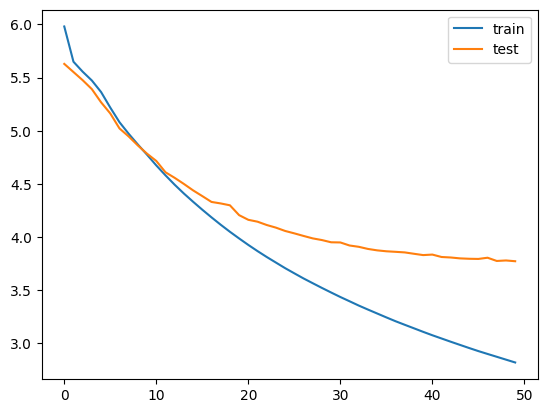

In [40]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [41]:
# 인퍼런스(추론) 모델 구현
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [42]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [43]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
   [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
   [decoder_outputs2] + [state_h2, state_c2])

In [44]:
def decode_sequence(input_seq):
   # 입력으로부터 인코더의 상태를 얻음
   e_out, e_h, e_c = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 토큰 생성
    # 디코딩을 시작하기 위해 디코더에 입력될 첫 번째 토큰, 즉 "시작 토큰"을 설정하는 역할​
   target_seq = np.zeros((1,1)) # target_seq는 2차원 배열로, 행이 1개이고 열이 1개, [[0]]
   target_seq[0, 0] = tar_word_to_index['sostoken']

   stop_condition = False
   decoded_sentence = ''
   while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

       output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c]) # 이 코드는 현재의 입력 토큰 및 인코더의 출력 및 상태값을 사용하여 디코더로 다음 토큰을 예측
       sampled_token_index = np.argmax(output_tokens[0, -1, :]) # 배치의 첫 번째 시퀀스(0), 시퀀스의 마지막 토큰(-1) 및 모든 어휘 확률 중 가장 가능성이 높은 다음 단어의 인덱스 선택
       sampled_token = tar_index_to_word[sampled_token_index]

       if (sampled_token!='eostoken'):
           decoded_sentence += ' '+sampled_token

       #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
       if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
           stop_condition = True

       # 길이가 1인 타겟 시퀀스를 업데이트
       target_seq = np.zeros((1,1))
       target_seq[0, 0] = sampled_token_index

       # 상태를 업데이트 합니다.
       e_h, e_c = h, c

   return decoded_sentence

In [45]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
   temp=''
   for i in input_seq:
       if (i!=0):
           temp = temp + src_index_to_word[i]+' '
   return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
   # [[YOUR CODE]]
   temp=''
   start_tok = tar_word_to_index['sostoken']
   end_tok = tar_word_to_index['eostoken']

   for i in input_seq:
       if (i!=0 and i!=start_tok and i!=end_tok):
           temp = temp + tar_index_to_word[i]+' '
   return temp

In [46]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

for i in range(50, 100):
   print("원문 :", seq2text(encoder_input_test[i]))
   print("실제 요약 :", seq2summary(decoder_input_test[i]))
   print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
   print("\n")

원문 : billionaire elon musk on friday shared the screenshot of satirical website article titled elon musk buys fortnite and it and tweeted had to be done ur welcome had to save these kids from eternal virginity the article quoted musk as saying fortnite is an online video game first released in and developed by epic games 
실제 요약 : you re welcome musk on article on him deleting fortnite 
1/1 [==============================] - 0s 21ms/step
예측 요약 :  musk shares new pic with musk elon musk


원문 : external affairs minister sushma swaraj on monday revealed that pm narendra modi told uk pm theresa may that liquor baron vijay mallya would be lodged where the uk jailed mahatma gandhi and jawaharlal nehru mallya facing an extradition trial in uk over money laundering charges by indian authorities had argued that the condition of indian jails is too poor 
실제 요약 : mallya will be jailed where british kept gandhi pm to uk 
1/1 [==============================] - 0s 20ms/step
예측 요약 :  swaraj asks pm mo